# **PRISM ALGORITHM**

# Installation

The main page for PRISM rules is from https://towardsdatascience.com/prism-rules-in-python-14d2cfd801a3/

In [155]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, make_blobs, fetch_openml
import sklearn.datasets as datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype


class PrismRules:
    def __init__(self, min_coverage=10, min_prob=0.75, nbins=3, verbose=0):
        """
        Class to generate PRISM rules for a supplied dataset.

        :param min_coverage: The minimum number of rows each rule must cover.
        :param min_prob: The minimum probability for each rule. The target class must be the target value in the
            remaining rows (the rows not covered by previous rules) with at least this probability.
        :param nbins: The number of bins each numeric column is divided into.
        :param verbose: If 0, no output is produced other than the induced rules. If 1, progress indication is
            presented as each rule is induced.
        """

        self.min_coverage = min_coverage
        self.min_prob = min_prob
        self.nbins = nbins
        self.bin_ranges = {}
        self.verbose = verbose
        self.default_target = None
        self.predict_dict = {}
        self.target_column = ""

        # For improved performance, integer values are used for each value. This dictionary maps the integer codes
        # to the original values, and is used to display the rules and target values. Where the column is numeric,
        # this maps to the bin label.
        self.int_to_values_map = {}

    def __get_next_term(self, df, target_col, target_val, cols_exclude_list):
        """
        Get the next term (a column-value pair) for the current rule.

        :param df: The dataframe for the current rule. This is the set of rows matching the rule so far.
        :param target_col: Target column
        :param target_val: The current target value within the target column
        :param cols_exclude_list: Columns for which we already have terms for this rule.
        :return: a single term in tuple format, with a column name and value from that column, along with the
            probability and coverage (frequency) of the rule on the remaining rows.
        """

        max_prob = -1
        # In the event of ties with respect to probability, we take the term with the greatest frequency
        max_prob_freq = 0
        term = None
        for col_name in df.drop(columns=[target_col]).columns:
            if col_name in cols_exclude_list:
                continue
            for val in df[col_name].unique():
                sub_df_1 = df[df[col_name] == val]
                sub_df_2 = df[(df[col_name] == val) & (df[target_col] == target_val)]
                prob = len(sub_df_2) / len(sub_df_1)
                freq = len(sub_df_2)
                if freq < self.min_coverage:
                    continue
                if (prob > max_prob) or ((prob == max_prob) and (freq > max_prob_freq)):
                    max_prob = prob
                    max_prob_freq = freq
                    term = (col_name, val, prob, freq)
        return term

    def __get_next_rule(self, df_rule, target_col, target_val):
        """
        Given a specified target_val in the target_col, find the first or next rule. If not the first, the dataframe
        should just contain rows not covered by the previous rules for this target value.

        :param df_rule: the full original dataframe, minus the rows covered by other rules for the current target
        :param target_col: the target column
        :param target_val: the target value
        :return: a list of terms for the new rule, and a dataframe with the rows for this rule
        """

        terms_list = []
        cols_exclude_list = []  # Do not create terms for the same feature in the same rule
        df = df_rule.copy()
        target_val_remaining = df[target_col].tolist().count(target_val)
        len_df = len(df)
        while target_val_remaining < len_df:
            term = self.__get_next_term(df, target_col, target_val, cols_exclude_list)
            if term is None:
                break
            col, val, prob, freq = term
            cols_exclude_list.append(col)
            if len(cols_exclude_list) == (len(df.columns) - 1):
                break
            df = df[(df[col] == val)]
            terms_list.append((term, df))
            target_val_remaining = df[target_col].tolist().count(target_val)
            len_df = len(df)

        # Check the terms list for the optimal set of terms, which is the set with the highest probability of the
        # target class given the terms.
        max_prob = 0
        max_prob_idx = -1
        max_prob_df = None
        for term_idx, term in enumerate(terms_list):
            if term[0][2] > max_prob:
                max_prob = term[0][2]
                max_prob_idx = term_idx
                max_prob_df = term[1]
        optimal_terms_list = terms_list[:max_prob_idx + 1]
        optimal_terms_list = [x for x, y in optimal_terms_list]

        if max_prob < self.min_prob:
            return None, None

        # Convert the integer codes used in the dataframe to the original values for the relevant column
        formatted_terms = []
        for t in optimal_terms_list:
            if t[1] == "NONE":
                formatted_terms.append(t)
            else:
                formatted_terms.append((t[0], self.int_to_values_map[t[0]][t[1]], t[2], t[3]))

        return formatted_terms, max_prob_df

    def __get_rules_for_target_val(self, df_full, target_col, target_val):
        """
        Get the full set of rules for the specified value in the target column
        :param df_full:
        :param target_col:  Name of target column
        :param target_val:  Value in the target column for which this execution of this function generates rules.
        :return: array of strings.
        """

        rules_for_val = []
        num_rows_curr_target = df_full[target_col].tolist().count(target_val)
        df = df_full.copy()  # Create a temporary dataframe that shrinks as the rules are formed
        is_first_rule = True
        target_val_remaining = df[target_col].tolist().count(target_val)
        while target_val_remaining > self.min_coverage:
            if self.verbose:
                print(f"  Determining next rule. {target_val_remaining:,} rows remaining for target class")
            num_rows_curr_target_remaining = df[target_col].tolist().count(target_val)
            terms_list, rule_df = self.__get_next_rule(df, target_col, target_val)
            if not terms_list:
                break

            if target_val in self.predict_dict:
                self.predict_dict[target_val].append(terms_list)
            else:
                self.predict_dict[target_val] = [terms_list]

            # Add a rule in string format representing the list of terms returned
            rule_str = ""
            for term in terms_list:
                rule_str += str(term[0]) + " = " + str(term[1]) + " AND "
            rule_str = rule_str[:-5]  # Remove the trailing "AND"
            num_matching_target = rule_df[target_col].tolist().count(target_val)
            rule_str += "\n   Support:  "
            if is_first_rule:
                rule_str += f"the target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} rows matching the rule "
                rule_str += "\n   Coverage: "
                rule_str += f"the rule matches: {num_matching_target} out of {num_rows_curr_target} rows "
                rule_str += f"for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
            else:
                rule_str += f"The target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} remaining rows matching the "
                rule_str += "rule"
                rule_str += "\n   Coverage: "
                rule_str += f"The rule matches: {num_matching_target} out of {num_rows_curr_target_remaining} rows "
                rule_str += f"remaining for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
                rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target_remaining):.3f}% of "
                rule_str += f"remaining rows for target value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target):.3f}% of total rows for target "
            rule_str += f"value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / len(df_full)):.3f}% of total rows in data"
            rules_for_val.append(rule_str)
            is_first_rule = False

            # Remove all rows for this rule
            df = df.loc[list(set(df.index) - set(rule_df.index))]
            target_val_remaining = df[target_col].tolist().count(target_val)
        return rules_for_val

    def __display_rules(self, df, target_col, rules_dict, display_stats):
        for target_val in rules_dict:
            print()
            print('........................................................................')
            print(f"Target: {self.int_to_values_map[target_col][target_val]}")
            print('........................................................................')
            if len(rules_dict[target_val]) == 0 and display_stats:
                print((f"  No rules imputed for target value {self.int_to_values_map[target_col][target_val]}. There "
                       f"are {df[target_col].tolist().count(target_val)} rows for this class."))
            for r in rules_dict[target_val]:
                if display_stats:
                    print(r)
                else:
                    print(r.split("\n")[0])

    def get_prism_rules(self, df, target_col, display_stats=True):
        """
        Given a dataframe with a specified target column, find a set of rules that describe the patterns associated
        with the target column. The rules are displayed in a formatted form.

        :param df: pandas dataframe. Must include the target column.
        :param target_col: Name of the target column
        :param display_stats: If True, the support and coverage for each rule will be displayed
        :return: array of strings, with each element of the array representing one rule.
        """

        # PRISM requires all columns be categorical, so bin any numeric features, including the target column if
        # necessary.
        new_vals_dict = {}
        for col_name in df.columns:
            if is_numeric_dtype(df[col_name]) and (df[col_name].nunique() > 10):
                try:
                    if self.nbins == 3:
                        vals = ['Low', "Med", 'High']
                        bin_ids, bin_ranges = pd.qcut(df[col_name], 3, labels=vals, retbins=True)
                    else:
                        vals = [f"Bin_{x}" for x in range(self.nbins)]
                        bin_ids, bin_ranges = pd.qcut(df[col_name], self.nbins, labels=vals, retbins=True)
                    self.bin_ranges[col_name] = bin_ranges
                    vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                    int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                    new_vals_dict[col_name] = bin_ids.map(vals_to_int_map)
                    self.int_to_values_map[col_name] = int_to_vals_map
                except:
                    # The qcut() method may fail if the data is sufficiently skewed, and the bins are non-unique, In
                    # this case we do not include the column in the model.
                    pass
            else:
                vals = df[col_name].unique()
                vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                new_vals_dict[col_name] = df[col_name].map(vals_to_int_map)
                self.int_to_values_map[col_name] = int_to_vals_map
        df = pd.DataFrame(new_vals_dict)

        # Remove any columns with only 1 unique value
        drop_cols = []
        for col_name in df.columns:
            if df[col_name].nunique() < 2:
                drop_cols.append(col_name)
        df = df.drop(columns=drop_cols)

        # Fill any NaN and None values
        for col_name in df.columns:
            if df[col_name].dtype.name == "category":
                df[col_name] = df[col_name].cat.add_categories("NONE").fillna("NONE")
            else:
                df[col_name] = df[col_name].fillna("NULL")

        # Loop through each value in the target column and find the set of rules for this value
        target_vals = sorted(df[target_col].unique())
        if self.verbose:
            print(f"Determining rules for each of {len(target_vals)} target classes:")
        rules_dict = {}
        for target_val in target_vals:
            if self.verbose >= 1:
                print(f"Determining rules for target class: {self.int_to_values_map[target_col][target_val]}")
            rules_dict[target_val] = self.__get_rules_for_target_val(df, target_col, target_val)

        self.__display_rules(df, target_col, rules_dict, display_stats)

        self.default_target = df[target_col].mode().values[0]
        self.target_column = target_col

        return rules_dict

    def predict(self, X_in, leave_unknown=False):
        X = X_in.copy()
        X = X.reset_index(drop=True)
        if leave_unknown:
            ret = ["NO PREDICTION"]*len(X)
        else:
            ret = [self.default_target]*len(X)
        is_set = [False]*len(X)

        for col_name in X.columns:
            if col_name not in self.bin_ranges:
                continue
            bin_ranges = self.bin_ranges[col_name]
            for i in range(len(X)):
                v = X.loc[i, col_name]
                for bin_idx, bin_limit in enumerate(bin_ranges):
                    if v < bin_limit:
                        X.loc[i, col_name] = bin_idx - 1
                        break
            if col_name in self.int_to_values_map:
                X[col_name] = X[col_name].map(self.int_to_values_map[col_name])

        for i in range(len(X)):
            row = X.iloc[i]
            found_rule = False
            for key in self.predict_dict.keys():
                rules = self.predict_dict[key]
                for rule in rules:
                    all_terms_true = True
                    for term in rule:
                        term_feature_name = term[0]
                        term_value = term[1]
                        if row[term_feature_name] != term_value:
                            all_terms_true = False
                            break
                    if all_terms_true:
                        ret[i] = key
                        is_set[i] = True
                        found_rule = True
                        break
                if found_rule:
                    break
        ret = pd.Series(ret).map(self.int_to_values_map[self.target_column])
        if leave_unknown:
            ret = ret.fillna("NO PREDICTION")
            ret = ret.astype(str)
        return ret

    def get_bin_ranges(self):
        if self.bin_ranges is None:
            print("No columns were binned.")
        else:
            return self.bin_ranges


# Example using the IRIS dataset from sklearn


In [156]:
# load IRIS dataset, features only
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/wine_data.csv"
df = pd.read_csv(url)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
0,13.73,1.50,2.70,22.5,101.0,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0,0
1,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.20,0.61,1.60,560.0,2
2,12.16,1.61,2.31,22.8,90.0,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495.0,1
3,13.07,1.50,2.10,15.5,98.0,2.40,2.64,0.28,1.37,3.70,1.18,2.69,1020.0,0
4,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


The unique values in the 'Y' column represent the different species of Iris flowers:
- 0: Iris-setosa
- 1: Iris-versicolor
- 2: Iris-virginica

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  Y    

In [158]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [159]:
df = df.sample(n=len(df)) # Shuffle the rows
print("Number of rows:", len(df))

Number of rows: 178


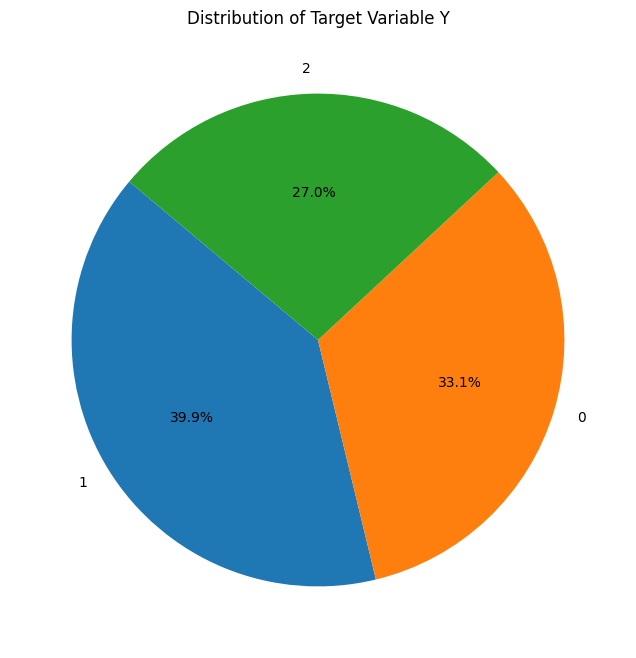

In [160]:
# Get the counts of each unique value in the 'Y' column
y_counts = df['Y'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(y_counts, labels=y_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Target Variable Y')
plt.show()

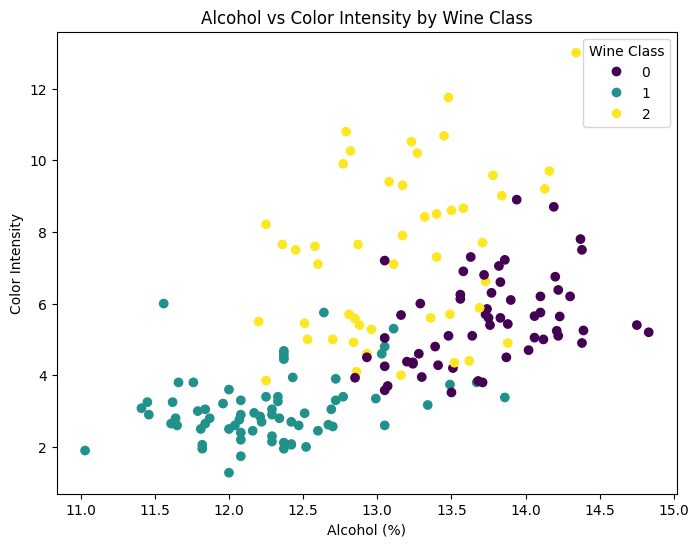

In [161]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['alcohol'], df['color_intensity'], c=df['Y'], cmap='viridis')
plt.xlabel('Alcohol (%)')
plt.ylabel('Color Intensity')
plt.title('Alcohol vs Color Intensity by Wine Class')
plt.legend(*scatter.legend_elements(), title="Wine Class")
plt.show()


The plot shows a clear separation among the three wine classes based on alcohol percentage and color intensity.
- Class 0 (purple) wines generally have higher alcohol levels (13–15%) and moderate color intensity (around 5–9).
- Class 1 (teal) wines have lower alcohol (11–13%) and lower color intensity (2–5).
- Class 2 (yellow) wines show medium alcohol (12–14%) but higher color intensity (6–12). 

This suggests that wines with higher alcohol and deeper color tend to belong to different classes than those with lighter alcohol and color levels.

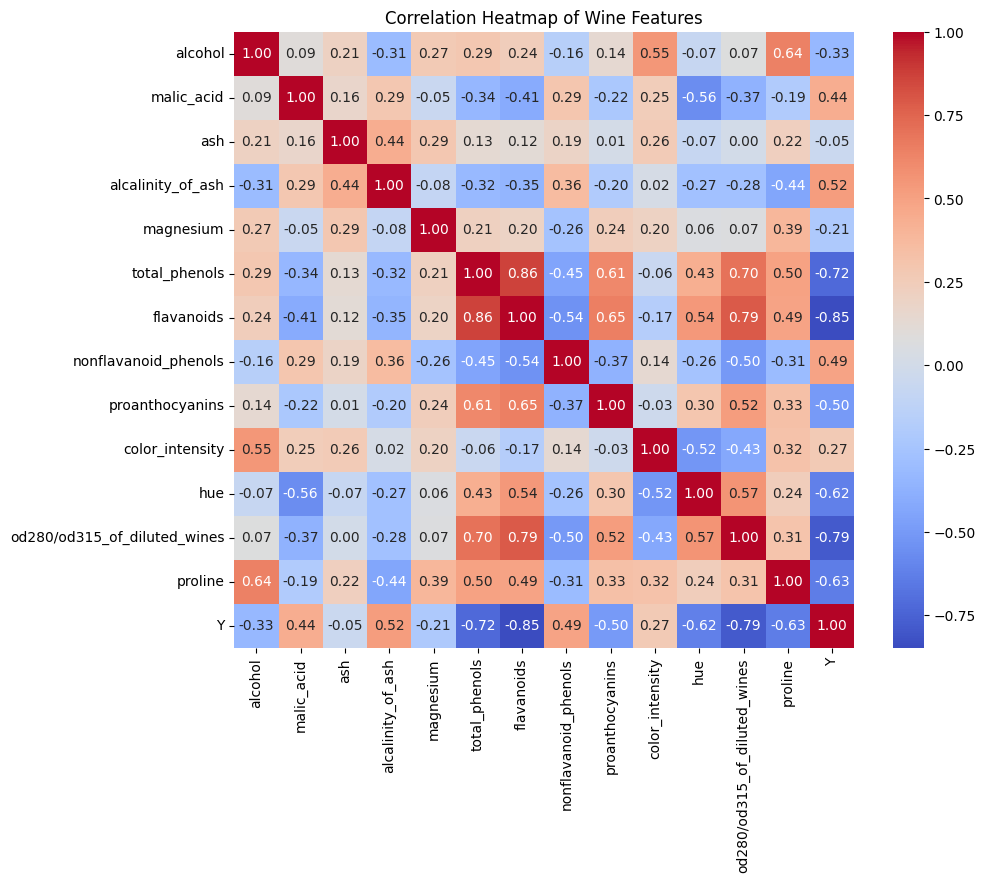

In [162]:
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Wine Features')
plt.show()


The heatmap displays correlations between wine chemical features.
- Strong positive correlations appear between flavanoids and total_phenols (0.86), meaning these compounds often increase together.
- Alcohol is moderately correlated with color_intensity (0.55) and proline (0.64), indicating that stronger wines often have richer color and more proline.
- Negative correlations are seen between flavanoids and color_intensity (-0.54), and between flavanoids and Y (-0.85), showing that these features vary inversely.

Overall, the heatmap reveals which chemical attributes are closely related, helping to understand feature influence on wine classification.


# Generate Rules with PRISM

In [163]:
# since we dont do any partitioning bcs we have to use both X and Y in our 'prism' model, so let's just use 120 rows for this training and the rest for the testing

# PRISM requires all columns be categorical, so bin any numeric features, including the target column if necessary, BUT there's a binning function in 'get_prism_rules', so we dont need to binning it manually first.

prism = PrismRules()
_ = prism.get_prism_rules(df.head(120), 'Y')


........................................................................
Target: 1
........................................................................
color_intensity = Low AND alcohol = Low
   Support:  the target has value: '1' for 100.000% of the 32 rows matching the rule 
   Coverage: the rule matches: 32 out of 47 rows for target value: '1'. This is:
      68.085% of total rows for target value: '1'
      26.667% of total rows in data

........................................................................
Target: 0
........................................................................
proline = High AND flavanoids = High
   Support:  the target has value: '0' for 100.000% of the 28 rows matching the rule 
   Coverage: the rule matches: 28 out of 41 rows for target value: '0'. This is:
      68.293% of total rows for target value: '0'
      23.333% of total rows in data

........................................................................
Target: 2
...................

Target 0:
Wines with high proline and high flavonoid levels tend to belong to Class 0. This means that wines rich in amino acids and antioxidants are most commonly classified in this group, indicating stronger and fuller-bodied wine characteristics.

Target 1:
Wines with low color intensity and low alcohol content are generally classified as Class 1. These wines are lighter, less alcoholic, and possibly more delicate in flavor compared to other classes.

Target 2:
Wines with low flavonoid levels or low hue, combined with high ash content, are typically classified as Class 2. This suggests that Class 2 wines have distinct mineral properties and a paler color tone compared to the others.

# Bin Ranges Result

In [164]:
# This section only to know the range of the bins
bin_ranges_data = []
for col, ranges in prism.get_bin_ranges().items():
    counts, _ = np.histogram(df[col], bins=ranges)
    for i in range(len(ranges) - 1):
        bin_ranges_data.append({
            'Column': col,
            'Bin': i,
            'Lower Bound': ranges[i],
            'Upper Bound': ranges[i+1],
            'Bin': i,
            'Count': counts[i]
        })

bin_ranges_df = pd.DataFrame(bin_ranges_data)
display(bin_ranges_df)

,Column,Bin,Lower Bound,Upper Bound,Count
0,alcohol,0,11.030000,12.556667,61
1,alcohol,1,12.556667,13.493333,60
2,alcohol,2,13.493333,14.830000,57
3,malic_acid,0,0.740000,1.646667,52
4,malic_acid,1,1.646667,2.436667,63
5,malic_acid,2,2.436667,5.800000,63
6,ash,0,1.360000,2.246667,51
7,ash,1,2.246667,2.453333,63
8,ash,2,2.453333,3.230000,64
9,alcalinity_of_ash,0,10.600000,18.000000,53


# Test on Y Pred

In [ ]:
# we use the rest of our data for testing, in this case is 58 rows
y_pred = prism.predict(df.tail(58).drop(columns=['Y']))
f1_score(df.tail(58)['Y'], y_pred, average=None)

array([0.8125    , 0.83018868, 0.90322581])

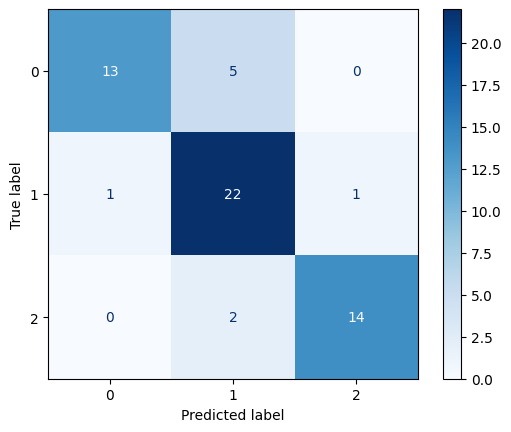

In [166]:
# We next display the confusion matrix.
labels = y_pred.unique()
cm = confusion_matrix(df.tail(58)['Y'], y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()

In [167]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(df.tail(58)['Y'], y_pred))

              precision    recall  f1-score   support

           0       0.93      0.72      0.81        18
           1       0.76      0.92      0.83        24
           2       0.93      0.88      0.90        16

    accuracy                           0.84        58
   macro avg       0.87      0.84      0.85        58
weighted avg       0.86      0.84      0.84        58



Which class is predicted best?

Class 2 is predicted best because it has the highest F1-score (0.90) and strong precision (0.93) and recall (0.88). This means the model is both accurate and consistent in identifying samples of class 2.

Are there misclassifications?

Yes, there are some misclassifications visible in the confusion matrix:
- For Class 0, 5 samples were incorrectly predicted as Class 1.
- For Class 1, 1 sample was predicted as Class 0 and 1 as Class 2.
- For Class 2, 2 samples were predicted as Class 1.

These errors indicate slight overlap between the classes, especially between Class 0 and Class 1.

In [170]:
# Create new data points for the Iris dataset
# You can change these values to test different scenarios
new_iris_data = {
    'alcohol': [14.0, 14.00],
    'malic_acid': [2.0, 2.0],
    'ash': [2.3, 2.2],
    'alcalinity_of_ash': [19.0, 11.0],
    'magnesium': [95.0, 95.0],
    'total_phenols': [2.2, 2.5],
    'flavanoids': [0.14, 0.5],
    'nonflavanoid_phenols': [0.14, 0.5],
    'proanthocyanins': [1.6, 1.5],
    'color_intensity': [7.0, 6.0],
    'hue': [0.7, 0.6],
    'od280/od315_of_diluted_wines': [3.2, 3.0],
    'proline': [550.0, 1400.0]
}

new_iris_df = pd.DataFrame(new_iris_data)

# Predict on the new Iris data using the prism model trained on Iris data
iris_prediction = prism.predict(new_iris_df)
# Assign predictions to a new column in the DataFrame
new_iris_df['Predicted Class'] = iris_prediction

# Display the new data and prediction
print("New Iris Data Points:")
display(new_iris_df)

New Iris Data Points:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Predicted Class
0,14.0,2.0,2.3,19.0,95.0,2.2,0.14,0.14,1.6,7.0,0.7,3.2,550.0,1
1,14.0,2.0,2.2,11.0,95.0,2.5,0.50,0.50,1.5,6.0,0.6,3.0,1400.0,1


Data Point 1

color_intensity = Low AND alcohol = Low → Class 1

Explanation:

This wine sample has a color intensity of 7.0, which the model interprets as relatively low to medium based on training ranges.
Its alcohol level of 14.0 is also considered moderate, fitting the Low Alcohol rule threshold used by PRISM.
Because both color_intensity and alcohol are within the “low” range for this dataset, PRISM matches it with the Class 1 rule.
In short, the model recognizes this wine as lighter and less intense, which are characteristics strongly linked to Class 1 wines in the rule set.


Data Point 2

color_intensity = Low AND alcohol = Low → Class 1

Explanation:

This wine also has a moderate color intensity (6.0) and alcohol content of 14.0, which again fall under the low thresholds according to the PRISM rule definitions.
Although it has high proline (1400) — which might suggest a possible fit with the Class 0 rule (proline = High AND flavanoids = High) — its flavanoids value (0.50) is too low to meet that Class 0 condition.
Therefore, the PRISM model prioritizes the color_intensity and alcohol features, classifying this sample as Class 1.


Summary

Both wine samples are predicted as Class 1 because they share two key features that strongly match the rule for this class:
Low color intensity
Low alcohol content
This indicates the model sees both wines as belonging to the same cluster of lighter, less alcoholic wines — a consistent and confident classification under PRISM’s learned patterns.

That's all. Thank you. Gbu